<a href="https://colab.research.google.com/github/naomifridman/DL_utils/blob/master/Deep_Learning_intro_part5_convolutional_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Deep Learning
# Part 5 - Convolutional Neural networks CNN

In [1]:
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


In [0]:
def show_list_images(imgs, titles=None):
    n_img = len(imgs)
    fig, m_axs = plt.subplots(1, n_img, figsize = (n_img*2, 4))
    i = 0
    for (c_im) in m_axs.T:
        c_im.imshow(imgs[i], cmap='gray')
        c_im.axis('off')
        if (titles is not None):
            c_im.set_title(titles[i])
        i+=1

In [0]:
def drow_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [3]:
from sklearn.utils import shuffle

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train , random_state=0)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11501568/11490434 [==============================] - 1s 0us/step
(60000, 'train samples')
(10000, 'test samples')


Lets view some images and labels:

(28, 28)
('Lables are: ', array([1, 2, 2, 9, 3, 6, 9, 8, 7, 0, 0, 3, 7, 0, 6], dtype=uint8))


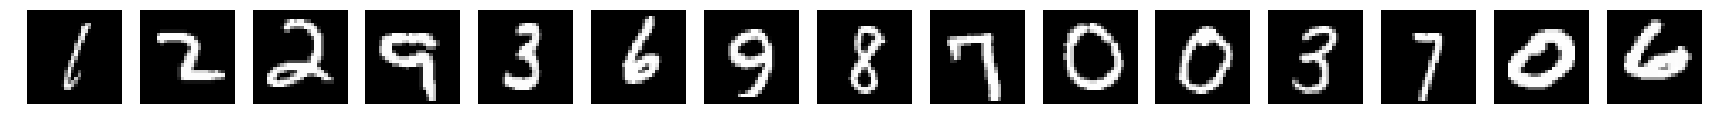

In [4]:
print(x_train[0].shape)
print('Lables are: ', y_train[15:30])
show_list_images(x_train[15:30])

Lets choose 2 images of as example to our discussion:

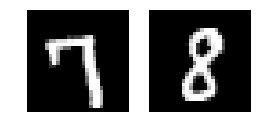

In [5]:
img7 = x_train[23]
img8 = x_train[97]
show_list_images([img7,img8])

### Convolution as feature detector
Convolution is actually a correlation between small part of the image and the filter. We can build a filter that represent a specific feature, horizontal edge for example. Mow we slide the filter along the image, and calculate the "response" or the correlation to of the filter to specific parts in the image. The output map of those responses, highlight the areas in the image that contain features which are correlated with the filter.<br>
#### Define a filter, and convolve it with the given images.
Lets start with a filter that detect horizontal edges.

[[-1 -2 -1]
 [ 0  0  0]
 [ 2  1  2]]


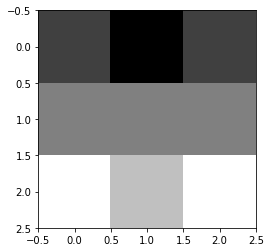

In [6]:
conv_filter1=np.array([[-1, -2,-1],
       [0,0, 0],
       [2, 1, 2]])
print(conv_filter1)
plt.imshow(conv_filter1, cmap='gray')

In [0]:
def conv2D(image, conv_filter):
    # as a demo code, here we ignore the shape check
    x_row, x_col = image.shape
    k_row, k_col = conv_filter.shape
    ret_row, ret_col = x_row - k_row + 1, x_col - k_col + 1
    ret = np.zeros((ret_row, ret_col))
    for y in range(ret_row):
        for x in range(ret_col):
            sub = image[y : y + k_row, x : x + k_col]
            ret[y,x] = np.sum(sub * conv_filter)
    return ret

def conv2D_list(images, conv_filter):
    ret=[]
    for im in images:
        ret.append(conv2D(im, conv_filter))
    return ret

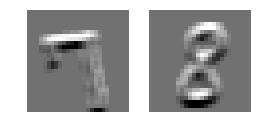

In [8]:
conv_image = conv2D_list([img7, img8], conv_filter1)
show_list_images(conv_image)

The transpose of this filter, will be a filter as well, that will detect the vertical edges.

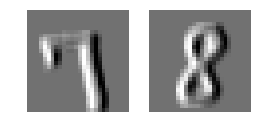

In [9]:
conv_image = conv2D_list([img7, img8], conv_filter1.T)
show_list_images(conv_image)

This way we can continue and design different features, to detect diagonals, specific corners,etc. Lets design few more edges.

In [0]:
conv_filter = []
conv_filter.append(conv_filter1)
conv_filter.append(conv_filter1.T)

In [0]:
cfilter=np.array([[0.5, 1,0],
       [-1.5,2, 2],
       [-2, -1, 1]])
conv_filter.append(cfilter)

In [0]:
cfilter=np.array([[1, 1.5,2],
       [-2,1, 1.5],
       [-1.5, -2,1]])
conv_filter.append(cfilter)
conv_filter.append(cfilter.T)

In [0]:
cfilter=np.array([[-1, -1.5,-2],
       [-2,0.5, 1.5],
       [1, 2, 2]])
conv_filter.append(cfilter)
conv_filter.append(cfilter.T)

Lets view the filters we built and their convolution with the example images. 

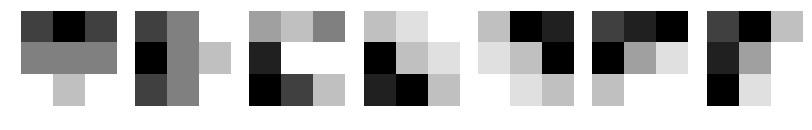

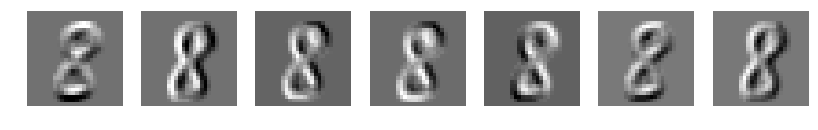

In [14]:
conv_image =[]
for f in conv_filter:
    conv_image.append(conv2D(img8, f))
show_list_images(conv_filter)
show_list_images(conv_image)

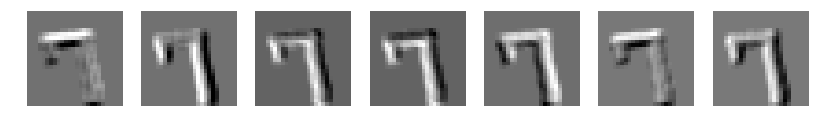

In [15]:
conv_image =[]
for f in conv_filter:
    conv_image.append(conv2D(img7, f))
show_list_images(conv_image)

To collect the information from the feature map of each filter, we can run another set of filter's on the feature map's. Lets view  the convolution of one of the filters with the feature map of the first step.

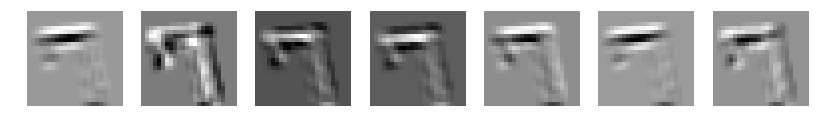

In [16]:
conv_image7 =[]
for im in conv_image:
    conv_image7.append(conv2D(im, conv_filter[0]))
show_list_images(conv_image7)

The performance of a convolutional neural networks, relies on the right filters. So, the idea here is that those filter's will be learn from the data, with the gradient decent method of decreasing the error with backpropogation.<br>
Up to here,we discussed the basic intuition to convolutional networks. lets start describing the scheme of building practical convolutional networks. Following are some basic definitions:

## 2D Convolutional neural networks building blocks
### Stride parameter
Until now we slided the filter,with steps of 1. But we can slide the filter in larger steps. The size of the sliding step, is the stride parameter. Default value is 1.
### Padding parameter
When we convolved a filter of size 3x3 with image size 28x28, the result was 26x26 image. If we don't want to decrease the size after each convolution, we can pad zeros for example, around the image,prior to convulution, to control the output size. Keras has "same" value for padding, that takes care that output size, will be the same as input.
### Stride parameter
Until now we slided the filter,with steps of 1. But we can slide the filter in larger steps. The size of the sliding step, is the stride parameter. Default value is 1.
### Convolution layer
Convolution layer, contain given number of filters, say F. each filter is convolving with the input image, all channels of it, and create feature map. So the output will be a stack of F feature maps, one per each filter. The size of the feature map's depends on the padding, stride and filter size.
### Maxpooling layer
Maxpooling layer, id a down-sampling layer. It helps prevent overfitting, and it decrease the size of the layer downwards to the number of classes we want to classify.<br>
In Maxpooling layer, we define a mask of size nxn, slide the mask over the feature maps, and choose the maximal number in the mask.


### Basic structure of Convolutional neural network
* Input layer - the input image, with defined padding.
* convolution block's -which are built from convolution and maxpooling layers.
* Dense Block - built from dense and droput layers,usually applied on flatten convolution output. Last layer for classification task is usually Softmax.

## The Kras network for Mnist classification

In [0]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop

In [0]:
# convert class vectors to binary class matrices
# create "dummy" variables for each category
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [20]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=x_train[0].shape)) #input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

W0915 16:50:40.877974 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 16:50:40.915945 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 16:50:40.924242 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 16:50:40.968928 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0915 16:50:40.973835 139877768435584 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

W0915 16:50:41.093729 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 16:50:41.103605 139877768435584 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0915 16:50:41.440557 139877768435584 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.2606 - acc: 0.9192 - val_loss: 0.0570 - val_acc: 0.9810
Epoch 2/20
60000/60000 [==============================] - 9s 155us/step - loss: 0.0856 - acc: 0.9750 - val_loss: 0.0384 - val_acc: 0.9865
Epoch 3/20
60000/60000 [==============================] - 9s 152us/step - loss: 0.0647 - acc: 0.9806 - val_loss: 0.0342 - val_acc: 0.9886
Epoch 4/20
60000/60000 [==============================] - 9s 152us/step - loss: 0.0524 - acc: 0.9841 - val_loss: 0.0313 - val_acc: 0.9900
Epoch 5/20
60000/60000 [==============================] - 9s 152us/step - loss: 0.0475 - acc: 0.9855 - val_loss: 0.0309 - val_acc: 0.9896
Epoch 6/20
60000/60000 [==============================] - 9s 150us/step - loss: 0.0404 - acc: 0.9874 - val_loss: 0.0278 - val_acc: 0.9903
Epoch 7/20
60000/60000 [==============================] - 9s 150us/step - loss: 0.0372 - acc: 0.9888 - val_loss: 0.0259 -

## Train Monitoring and Model evaluation

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.025766946106385604)
('Test accuracy:', 0.992)


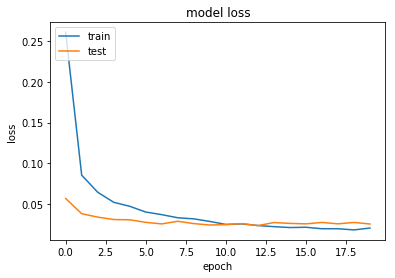

In [26]:
drow_history(history, 'loss')

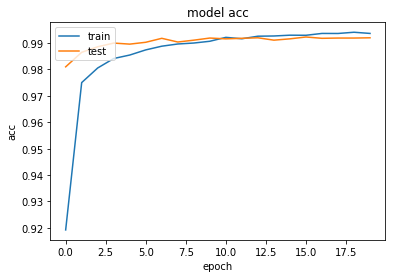

In [27]:
drow_history(history, 'acc')

Sources:
    * https://www.youtube.com/watch?v=ACU-T9L4_lI
    * CS231n Winter 2016: Lecture 7: Convolutional Neural Networks https://www.youtube.com/watch?v=LxfUGhug-iQ
    * Minsy data set - THE MNIST DATABASE of handwritten digits http://yann.lecun.com/exdb/mnist/
    http://cs231n.stanford.edu Anfrej Karpathy

### Articles:
* Krizhevsky, A., Sutskever, I., and Hinton, G. **Imagenet
classification with deep convolutional neural networks.** In Advances in Neural Information Processing Systems 25, pp. 1106–1114, 2012.
* V. Nair and G. E. Hinton. **Rectified linear units improve restricted boltzmann machines.**  27th International Conference on Machine Learning, 2010.
* D.E. RummelhartG.E. HintonR.J. Williams. **Learning Internal Representations by Error Propagation** Jan 1986 Nature.
